In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('classic')
import numpy as np
import datetime as dt
from datetime import timedelta
import simulate
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 100)

In [190]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

start = dt.date(2020, 1, 1)
end = dt.date(2080, 1, 31)


Market = simulate.Market(spx.iloc[-7500:, -2], start, end)

## Setting up functions to calculate performance

In [76]:
def nd(s, pv_u, dst, td, cash, phase, g):
    # determine new debt dependent on phase
	# dont aquire debt or repay debt in phase 3 or 4
    if phase == 3 or phase == 4:
        return 0, s
    
    if phase == 1:
        upper_debt_limit = pv_u/(1+g)
        new_debt = min(max(g*s, g*(pv_u-td)), dst-pv_u-s)
        return (new_debt, s)
    
    if phase == 2: 
        stocks_sold = max(pv_u-dst, 0)
        debt_repayment = min(td, s + stocks_sold)
        leftover_savings = max(s-debt_repayment - stocks_sold, 0)
        return -debt_repayment, leftover_savings

In [77]:
def update_cash(phase, pv_u, tv_u, s, cash, pi_rf, pi_hat):
    if phase <= 3:
        return 0, s
    
    if phase == 4:
        
        desired_cash = (1-pi_rf)*(tv_u+s)
        desired_savings = (pi_rf)*(tv_u+s)
        change_in_stock = desired_savings - pv_u
        
        #check_pi = (pv_u + change_in_stock)/(tv_u+s)
        
        return desired_cash, change_in_stock

In [78]:
def phase_check(phase, pi_rf, pi_rm, pi_hat, td):
    if phase == 4:
        return 4
    
    if td > 0:
        #has target not been reached?
        if pi_hat < pi_rm and phase <= 1:
            return 1
        else:
            # if target has been reached once and debt remains, stay in phase 2
            return 2
    
    #if target has been reached and no debt remains
    #is the value still above the target?
    if pi_hat < pi_rf:
        return 3
    else:
        return 4

In [79]:
def calc_pi(gamma, sigma, mr, rate, cost = 0):
    return (mr - cost - rate)/(gamma * sigma)

In [80]:
update_cash(4, 900, 1000, 50, 100, 0.8333333333333333333, 0.9)

(174.99999999999997, -25.0)

## Combining with investment profile

In [82]:
def calculate_return(savings, market_returns, gearing_cap, pi_rf, pi_rm, rf, rm):
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    # Setting up constants and dataframe for calculation
    ses = savings.sum()     # Possibly add more sophisticated discounting
    ist = pi_rm*ses
    columns = ['period', 'savings', 'cash', 'new_debt', 'total_debt', 'nip', 'pv_p', 
               'interest', 'market_returns', 'pv_u', 'tv_u', 'dst', 'phase', 'pi_hat', 'ses']
    
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['ses'] = ses
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    
                      
    # Period 0 primo
    pp.loc[0, 'cash'] = 0
    pp.loc[0, 'new_debt'] = pp.loc[0, 'savings']*gearing_cap
    pp.loc[0, 'total_debt'] = pp.loc[0, 'new_debt']
    pp.loc[0, 'nip'] = pp.loc[0, 'new_debt'] + pp.loc[0, 'savings']
    pp.loc[0, 'pv_p'] = pp.loc[0, 'nip']
    pp.loc[0, 'pi_hat'] =  pp.loc[0, 'pv_p']/ses
    
    # Period 0 ultimo
    pp.loc[0, 'interest'] = pp.loc[0, 'new_debt']*rm                   
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']                 
    pp.loc[0, 'tv_u'] = pp.loc[0, 'pv_u'] + pp.loc[0, 'cash']
    pp.loc[0, 'dst'] = ist
    pp.loc[0, 'phase'] = 1
    
              
    
    # Looping over all reminaning periods
    for i in range(1, len(savings)):
 

        # Period t > 0 primo
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) 
        pp.loc[i, 'new_debt'], pp.loc[i, 'savings'] = nd(pp.loc[i, 'savings'], pp.loc[i-1, 'pv_u'], 
                                                         pp.loc[i-1, 'dst'], pp.loc[i-1, 'total_debt'],
                                                         pp.loc[i-1, 'cash'], pp.loc[i-1, 'phase'], gearing_cap)
        pp.loc[i, 'total_debt'] = pp.loc[i-1, 'total_debt'] + pp.loc[i, 'new_debt']
        
        pp.loc[i, 'cash'], pp.loc[i, 'savings'] = update_cash(pp.loc[i-1, 'phase'], pp.loc[i-1, 'pv_u'], pp.loc[i-1, 'tv_u'],
                                                                     pp.loc[i, 'savings'], pp.loc[i, 'cash'], pi_rf, pp.loc[i-1, 'pi_hat'])

        pp.loc[i, 'nip'] = pp.loc[i, 'savings'] + max(0, pp.loc[i, 'new_debt'])
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'nip']        
        
        
        # Period t > 0 ultimo
        pp.loc[i, 'interest'] = max(pp.loc[i, 'total_debt']*rm, 0)
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])-pp.loc[i, 'interest']
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
        pp.loc[i, 'pi_hat'] = min(pp.loc[i, 'pv_u']/ses, pp.loc[i, 'pv_u']/pp.loc[i, 'tv_u'])
        
        pp.loc[i, 'phase'] = phase_check(pp.loc[i-1, 'phase'], pi_rf, pi_rm, pp.loc[i, 'pi_hat'], pp.loc[i, 'total_debt'])
        target_pi = pi_rm if pp.loc[i-1, 'phase'] < 3 else pi_rf
        pp.loc[i, 'dst'] = max(pp.loc[i, 'tv_u']*target_pi, ist)  # Moving stock target
        #pp.loc[i, 'dst'] = max(pp.loc[i-1, 'dst'], max(pp.loc[i, 'tv_u']*target_pi, ist))  # Moving stock target        

    return pp

In [83]:
def calculate100return(savings, market_returns):
     # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    columns = ['period', 'savings', 'pv_p', 'market_returns', 'tv_u']
        
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)
    
    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    pp.loc[0, 'pv_p'] = pp.loc[0, 'savings']
    pp.loc[0, 'tv_u'] = pp.loc[0, 'savings']
    
    for i in range(1, len(savings)):
 
        # Period t > 0 primo
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'tv_u'] + pp.loc[i, 'savings']        
        
        # Period t > 0 ultimo
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])
    
    return pp

In [84]:
def calculate9050return(savings, market_returns, rf):
    # Strategy where 90% of value is initially invested in stocks, rest in risk free asset
    # Ratio of stocks falls linearly to 50% by age 65 and stays there
    
    # Running controls
    assert len(savings) == len(market), 'Investment plan should be same no of periods as market' 
    
    columns = ['period',  'savings', 'cash', 'pv_p', 'market_returns', 'pv_u', 'tv_u', 'ratio']
        
    pp = pd.DataFrame(np.empty((len(savings), len(columns))), columns = columns)

    pp['period'] = range(len(savings))
    pp['market_returns'] = market_returns
    pp['savings'] = savings
    pp.loc[0, 'market_returns'] = 0
    pp.loc[0, 'pv_p'] = pp.loc[0, 'savings']*0.9
    pp.loc[0, 'cash'] = pp.loc[0, 'savings']*0.1
    pp.loc[0, 'pv_u'] = pp.loc[0, 'pv_p']    
    pp.loc[0, 'tv_u'] = pp.loc[0, 'savings']
    pp.loc[0, 'ratio'] = 90
    
    for i in range(1, len(savings)):
        ratio = max(90 - pp.loc[i, 'period'], 50)
        pp.loc[i, 'ratio'] = ratio
        
        # Period t > 0 primo
        pp.loc[i, 'pv_p'] = pp.loc[i-1, 'pv_u'] + pp.loc[i, 'savings']*(ratio/100)        
        pp.loc[i, 'cash'] = pp.loc[i-1, 'cash']*(1+rf) + pp.loc[i, 'savings']*(1-ratio/100)
        
        # Period t > 0 ultimo
        pp.loc[i, 'pv_u'] = pp.loc[i, 'pv_p']*(1+pp.loc[i, 'market_returns'])
        pp.loc[i, 'tv_u'] = pp.loc[i, 'pv_u'] + pp.loc[i, 'cash']
    
    return pp

In [205]:
savings_year = pd.read_csv('investment_plan_year.csv', sep=';', index_col=0)
savings_year.index = pd.to_datetime(savings_year.index, format='%Y')
savings_month = (savings_year.resample('BMS').pad()/12)['Earnings'].values
savings_year = savings_year['Earnings'].values

In [221]:
investments = savings_year*0.05


rf = 0.02
rm = 0.03

gamma = 1.5
sigma = 0.20**2
mr = 0.07

pi_rf = calc_pi(gamma, sigma, mr, rf, cost = 0)
pi_rm = calc_pi(gamma, sigma, mr, rm, cost = 0)
print('pi_rf:', pi_rf, ' pi_rm:', pi_rm)

market = Market.draw(random_state = 1, freq='Y').asfreq('BYS', 'pad')
  
      
port = calculate_return(investments, market['Price'].pct_change().values, 1, pi_rf, pi_rm, rf, rm)
port100 = calculate100return(investments, market['Price'].pct_change().values)
port9050 = calculate9050return(investments, market['Price'].pct_change().values, rf)

pi_rf: 0.8333333333333333  pi_rm: 0.6666666666666666


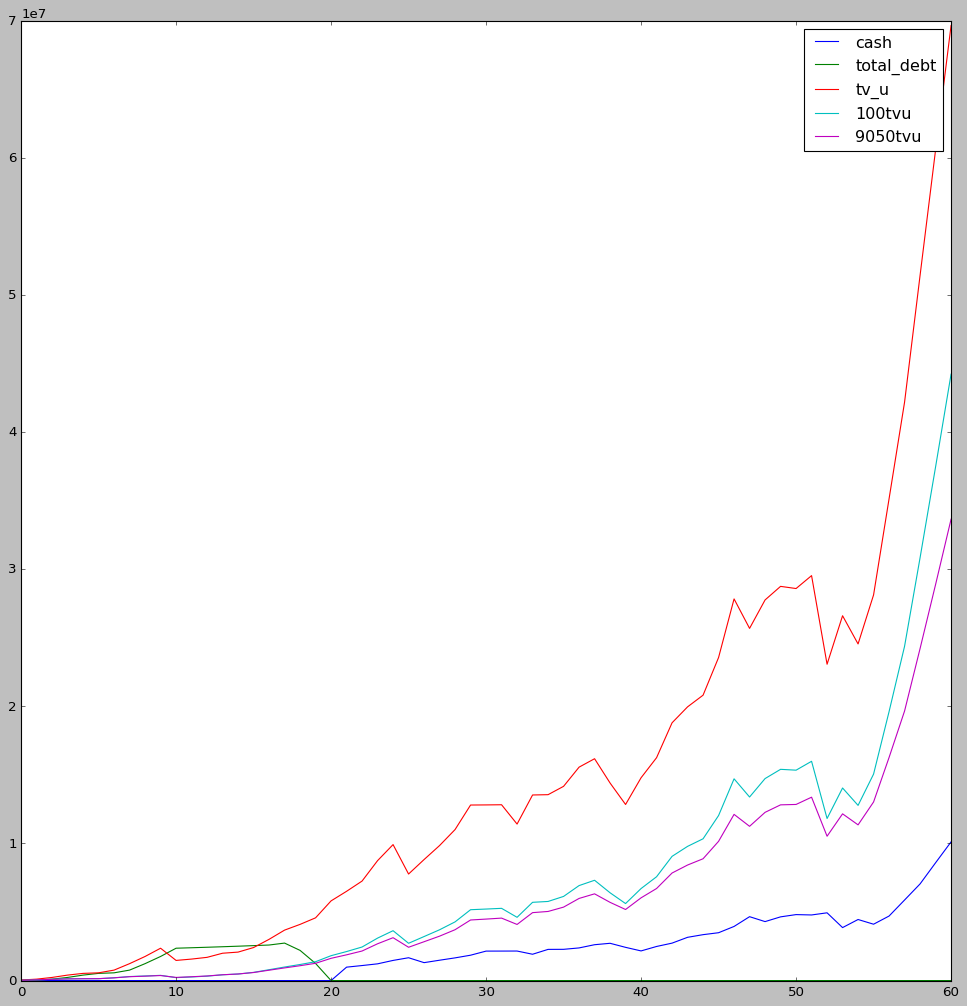

In [222]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
vars_to_plot = ['cash', 'total_debt', 'tv_u', '100tvu', '9050tvu']
port['100tvu'] = port100['tv_u']
port['9050tvu'] = port9050['tv_u']
ax.plot(port.loc[:,vars_to_plot])
ax.legend(vars_to_plot)

In [213]:
port

,period,savings,cash,new_debt,total_debt,nip,pv_p,interest,market_returns,pv_u,tv_u,dst,phase,pi_hat,ses,100tvu,9050tvu
0,0,"20,000.00",0.00,"20,000.00","20,000.00","40,000.00","40,000.00",600.00,0.00,"40,000.00","40,000.00","3,193,289.20",1.00,0.01,"4,789,933.80","20,000.00","20,000.00"
1,1,"21,000.00",0.00,"21,000.00","41,000.00","42,000.00","82,000.00","1,230.00",0.37,"111,117.45","111,117.45","3,193,289.20",1.00,0.02,"4,789,933.80","56,173.73","54,618.63"
2,2,"22,050.00",0.00,"70,117.45","111,117.45","92,167.45","203,284.91","3,333.52",0.03,"205,574.69","205,574.69","3,193,289.20",1.00,0.04,"4,789,933.80","80,387.57","78,682.93"
3,3,"23,152.60",0.00,"94,457.24","205,574.69","117,609.84","323,184.53","6,167.24",-0.01,"315,165.66","315,165.66","3,193,289.20",1.00,0.07,"4,789,933.80","102,946.95","101,451.57"
4,4,"24,310.20",0.00,"109,590.97","315,165.66","133,901.17","449,066.82","9,454.97",-0.37,"273,201.14","273,201.14","3,193,289.20",1.00,0.06,"4,789,933.80","80,099.46","84,416.72"
5,5,"25,525.60",0.00,"25,525.60","340,691.26","51,051.20","324,252.34","10,220.74",0.07,"338,153.84","338,153.84","3,193,289.20",1.00,0.07,"4,789,933.80","113,482.87","117,083.52"
6,6,"26,802.00",0.00,"26,802.00","367,493.26","53,604.00","391,757.84","11,024.80",0.02,"389,358.30","389,358.30","3,193,289.20",1.00,0.08,"4,789,933.80","143,373.50","146,922.81"
7,7,"28,142.00",0.00,"28,142.00","395,635.26","56,284.00","445,642.30","11,869.06",-0.01,"427,316.83","427,316.83","3,193,289.20",1.00,0.09,"4,789,933.80","169,030.60","173,377.07"
8,8,"29,549.20",0.00,"31,681.57","427,316.83","61,230.77","488,547.60","12,819.50",0.13,"538,675.52","538,675.52","3,193,289.20",1.00,0.11,"4,789,933.80","224,166.02","225,357.84"
9,9,"31,026.60",0.00,"111,358.70","538,675.52","142,385.30","681,060.82","16,160.27",0.15,"764,756.87","764,756.87","3,193,289.20",1.00,0.16,"4,789,933.80","292,608.66","288,842.94"


## Characteristics of strategies

In [118]:
std = port.loc[:, ['tv_u', '100tvu', '9050tvu']].pct_change().std()

horizon = Market.years-1
mean_return = (port.loc[horizon, ['tv_u', '100tvu', '9050tvu']]/port.loc[0, ['tv_u', '100tvu', '9050tvu']])**(1/horizon)-1

In [119]:
mean_return

tv_u                      0.14
100tvu                    0.15
9050tvu                   0.14
dtype: float64

In [120]:
std

tv_u                      0.32
100tvu                    0.32
9050tvu                   0.29
dtype: float64

In [121]:
sharpe = mean_return/std

In [122]:
sharpe

tv_u                      0.43
100tvu                    0.46
9050tvu                   0.49
dtype: float64